Notebook to compute the eigenmode decomposition of 1D diffusion utilizing 
random walk methodology. Used to validate modal markov formulation for calcium
diffusion. Simple 1d diffusion with no reactions.

11 nodes.

author: Margot Wagner
date created: 6/16/22

# Setup

In [1]:
import numpy as np
from numpy.linalg import eig
import matplotlib
import matplotlib.pyplot as plt
import math
from typing import Union, Tuple
# import modules for random walk and eignen implementations
import sys
sys.path.insert(0, '../../src/')
import random_walk as rw

### Disable Scrolling Cells

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
%load_ext blackcellmagic

## Notation
(from [stochastic-eme-soln.tex](https://www.overleaf.com/project/60ae85bacdfc625489517928))

Variable | Description
:--------|:-----------
     $N$ | total number of particles
     $i$ | spatial node index
     $k$ | eigenmode index
   $p_i$ | probability of finding a particle at spatial node $i$
 $v_{ik}$| eigenvector value for the $i$th node and $k$th mode
    $n_i$| the number of particles at node $i$; $$n_i = \sum_k m_k \text{v}_{i k}$$
    $m_k$| the number of particles in eigenmode $k$; $$m_k = \sum_i n_i \text{v}_{i k}$$
    $p_i$| probability of finding a particle in spatial node $i$; normalized number of particles at node $i$; $$p_i = \frac{n_i}{N} = \frac{1}{N} \sum_k m_k \text{v}_{i k}$$
    $q_k$| probability of finding a particle in eigenmode $k$; normalized number of particles in eigenmode $k$; $$q_k = \frac{m_k}{N} =  \sum_i n_i \text{v}_{i k}$$

# 1D Random Walk Diffusion Simulation
Implementation similar to GeeksforGeeks' [Random Walk (Implementation in Python)](https://www.geeksforgeeks.org/random-walk-implementation-python/).

<div>

</div>

## Constants

In [ ]:
n_particles = 50  # number of molecules

# MESH
n_spatial_locs = 11  # define number of grid points along 1D line
particle_start_loc = 5

# SIMULATION
n_time_pts = 1000  # number of time points
dt = 1  # time step (usec)
line_length = 4  # total length of diffusion line (um)
diffusion_constant_D = 2.20e-4  # Calcium diffusion coeff (um^2/usec)

In [4]:
# Unused

'''
min_loc = 0             # minimum position
max_loc = n_spatial_locs - 1  # maximum position
last_elem_i = -1        # index for the last element in a list 
'''

'\nmin_loc = 0             # minimum position\nmax_loc = n_spatial_locs - 1  # maximum position\nlast_elem_i = -1        # index for the last element in a list \n'

## Init a Random Walk Object

In [10]:
random_walk = rw.RandomWalk(
    n_particles=n_particles,
    n_spatial_locs=n_spatial_locs,
    n_time_pts=n_time_pts,
    particle_start_loc=particle_start_loc,
    # optional params below:
    dt=dt,
    line_length=line_length,
    diffusion_constant_D=diffusion_constant_D,
)

## Run Simulation

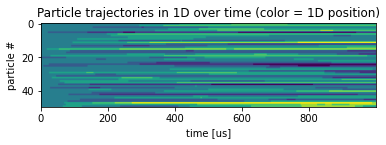

In [16]:
# Get each particle's location over time
particle_locs = random_walk.run_simulation()

# Visualize the output array
plt.imshow(particle_locs, aspect=5)
plt.ylabel('particle #')
plt.xlabel('time [us]')
plt.title('Particle trajectories in 1D over time (color = 1D position)')
plt.show()

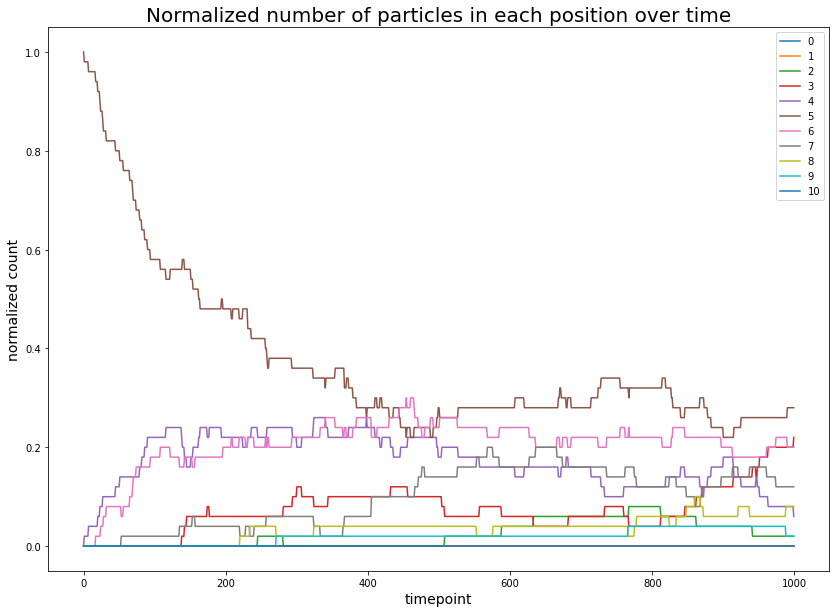

In [17]:
# Reformat the output to instead collect # particles at each location
unnorm_n_per_loc, n_per_loc, mean_n_per_loc = random_walk.postprocess_run(
    particle_locs=particle_locs,
    plot=True
)

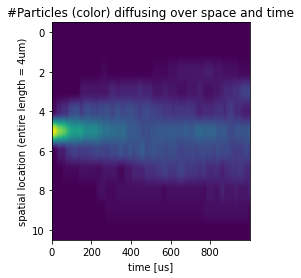

In [18]:
# Also look at the unnormalized output:
plt.imshow(unnorm_n_per_loc, aspect=100)
plt.xlabel('time [us]')
plt.ylabel('spatial location (entire length = {}um)'.format(line_length))
plt.title('#Particles (color) diffusing over space and time')
plt.show()

## Variance
https://mathworld.wolfram.com/RandomWalk1-Dimensional.html

$p_l:$ probability of taking a step to the left ($p$ in the article)

$p_r:$ probability of taking a step to the right ($q$)

$p_0:$ probability of remaining in place (not used in the article)

$n_l:$ number of steps taken to the left ($n_2$)

$n_r:$ number of steps taken to the right ($n_1$)

$N_T:$ number of time steps ($N$ is the number of steps in the article)

Now, sum of the probabilities would be 1:

$p_l + p_r + \color{red}{p_0} = 1$

And the total number of steps taken is:

$n_l + n_r + \color{red}{n_0} = \color{red}{N_T}$

Now let's formulate the probability of a particle moving left, right, or remaining in the same location as a multinomial distribution. So we have:

$N_T$ trials, with three possible outcomes:
- step to the left (occurs $n_l$ times)
- step to the right (occurs $n_r$ times)
- remain in the same location (occurs $n_0$ times)

The probability of taking these steps becomes, using the [multinomial formula](https://en.wikipedia.org/wiki/Multinomial_distribution):

$ P = \frac{\displaystyle N_T!}{\displaystyle n_l! n_r! n_0!} p_r^{n_r} p_l^{n_l} p_0^{n_0} $

(Note: this can be thought of as a permutation problem. Say we have $N_T$ blanks that can be filled with 'L', 'R', or '0', then all possible arrangements of these blanks, using the multiplication rule, is $N_T!$, but we divide out duplicate arrangements since $n_l$, $n_r$, and $n_0$ labels are identical.)

The variance is:
$\text{Var}(left) = N_T p_l (1-p_l) = \text{Var}(right)$, if $p_l = p_r$

In [29]:
random_walk.get_variance()

3.0448704687500004e-05

In [28]:
n_time_pts * jump_probability * (1-jump_probability)

1.6609819359375002

In [30]:
# Expectation
## This is the expected number of times a particle jumps to the left (right) over n_time_pts:
n_time_pts * jump_probability

1.66375

So we expect a particle to jump left (right) $1.663 \pm \sqrt{1.661}$ times, over 1000 time steps.

## How often do they jump?
Looking at trajectories...

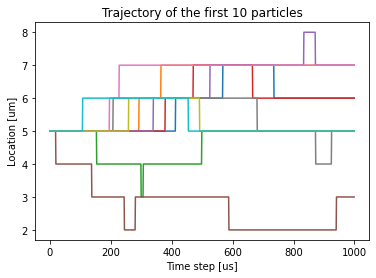

In [39]:
particles_to_plot = 10
plt.plot(particle_locs[:particles_to_plot].T)
plt.xlabel('Time step [us]')
plt.ylabel('Location [um]')
plt.title(f'Trajectory of the first {particles_to_plot} particles')
plt.show()

## Probability of jumping left/right

Rate constant: $k = \frac{D}{dx^2}$

$P(jumping) = kdt$

<div>
<img src="attachment:get_jump_probability.svg" width="500"/>
</div>

In [24]:
# find probability of moving one step
jump_probability, jump_rate_constant_k = random_walk.get_jump_probability()

print('P(jump) = {}\nk(rate) = {}/us'.format(jump_probability, jump_rate_constant_k))
# Note: dt = 1 (us), so these look the same

P(jump) = 0.00166375
k(rate) = 0.00166375/us


## Eigenmode Markov Model

### Transition Matrix
<div>
<img src="attachment:transition_rate.svg" width="500"/>
</div>

This uses the rate constant  $k$ as defined above:

$$k = \frac{D}{dx^2}$$

where $D$ is the diffusion constant, and $dx$ is the distance between spatial nodes.

This leads us to the transition matrix $A$:

$$ A = \begin{bmatrix} 
 -k &   k &   0 &   0 &  0 & \ldots &   0 \\
  k & -2k &   k &   0 &  0 & \ldots &   0 \\
  0 &   k & -2k &   k &  0 & \ldots &   0 \\
  0 &   0 &   k & -2k &  k & \ldots &   0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
  0 &   0 &   0 &   0 &  k &    -2k &   k \\
  0 &   0 &   0 &   0 &  0 &      k &  -k \\
\end{bmatrix}
$$

In [ ]:
def transition_matrix_maker(
    diffusion_rate_constant_k: Union[int,float], 
    n_spatial_locs: int
    ) -> np.ndarray:
    """Builds and returns the transition matrix for the 1D random walk case 
    as given.

    params:
        diffusion_rate_constant_k:
            jump rate constant
        n_spatial_locs:
            number of grid points along line

    returns:
        transition matrix
    """

    # Define A (transition) matrix
    A = np.zeros(
        (n_spatial_locs, n_spatial_locs)
    )  # transition probability between grid points

    # Transition matrix is given by the ODE dynamics equation (using k-values)
    vec_diag = np.full(n_spatial_locs, (-2 * diffusion_rate_constant_k))
    vec_off_diag = np.full(
        (n_spatial_locs - 1), diffusion_rate_constant_k
    )  # off-diagonal values

    # create transition matrix
    A = (
        np.diag(vec_diag, k=0)
        + np.diag(vec_off_diag, k=1)
        + np.diag(vec_off_diag, k=-1)
    )
    A[0, 0] = -diffusion_rate_constant_k
    A[n_spatial_locs - 1, n_spatial_locs - 1] = -diffusion_rate_constant_k

    return A

In [ ]:
# find probability of moving one step
kdt, k = get_jump_probability(
    line_length, n_spatial_locs, diffusion_constant_D, dt
)

A = transition_matrix_maker(-k, n_spatial_locs)

# Use a diverging colormap
## https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging
cmap = matplotlib.cm.bwr

# Center the colormap on 0
## https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
divnorm = matplotlib.colors.TwoSlopeNorm(vcenter=0) #, vmin=-.01, vmax=.01)

plt.imshow(A, cmap=cmap, norm=divnorm)

plt.title("Transition Matrix $A$")
A

## Eigenvectors, Eigenvalues, and Eigenmodes

In [ ]:
def get_eigenmode(eigenvalues, t):
    return np.exp(-eigenvalues * t)

def make_eigenmode_plots(eigenvalues):
    time = np.array(range(n_time_pts))
    alpha = 1 # transparency
    for λ in eigenvalues:
        plt.plot(
            time, 
            get_eigenmode(λ, time),
            c = 'red',
            alpha = alpha,
            label = 'λ={:.4f}'.format(λ)
        )
        
        alpha *= .66 # use transparency to generate a gradient in colors

    plt.xlabel('t [µs]')
    plt.ylabel('$e^{-λt}$')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

def make_eigenvector_plots(eigenvalues, eigenvectors):

    '''
    plt.imshow(eigenvectors.transpose())
    plt.xlabel('Spatial Node')
    plt.ylabel('$v_{i, k}$')
    plt.figure()
    '''
    
    num_nodes, num_modes = eigenvectors.shape
    alpha = 1
    for k in range(num_modes):
        λ = eigenvalues[k]
        v = eigenvectors[:, k]
        #print(v)
        
        plt.plot(v, 
                 '*-', 
                 c = 'red',
                 alpha = alpha,
                 label = 'λ={:.4f}'.format(λ))
        
        alpha *= .66 # use transparency to generate a gradient in colors
        
    plt.xlabel('Spatial Node')
    plt.ylabel('Eigenvector')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    
def get_eigenvalues_and_vectors(A: np.ndarray, 
                                print_output=True, 
                                plot_eigenmodes=False,
                                plot_eigenvectors=False,
                                ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns the sorted eigenvalues and eigenvectors of matrix A

    Args:
        A: transition matrix

    Returns:
        eigenvalues: 1d matrix of size n_spatial_locs
        eigenvectors: 2d matrix of eigenvectors where columns
                correspond to eigenvalues (ie evec[:,k] <-> eval[k])
        eval_sort_index: argsort index array used to sort eigenvalues.
                Can be used to sort via matrix[eval_sort_index]

    """

    # get eigenvalues/eigenvectors
    # eigenmode[k] is composed of eigenvector[:, k] and eigenvalue[k]
    e_val_unsorted, e_vec_unsorted = eig(A)
    np.set_printoptions(suppress=True)  # gets rid of scientific notation
    
    # sort values and vectors
    eigenvalues = np.sort(e_val_unsorted)
    eval_sort_index = np.argsort(e_val_unsorted)
    eigenvalues[0] = round(eigenvalues[0])
    eigenvectors = e_vec_unsorted[:, eval_sort_index]
    
    # normalize eigenvector values
    eigenvectors /= eigenvectors[0, 0] #np.abs(eigenvectors[0, 0])

    if print_output:
        print("EIGENVALUES")
        print(" ", end="")
        [print(i, end=" " * 5) for i in range(n_spatial_locs)]
        print()
        print(eigenvalues.round(decimals=3))
        print()
        
        print("EIGENVECTORS")
        # eigenvector columns correspond to eigenvalues 
        # (ie evec[:,k] <-> eval[k])
        print("   ", end="")
        [print(i, end=" " * 4) for i in range(n_spatial_locs)]
        print()
        print(eigenvectors.round(decimals=1))
        print()
        
    if plot_eigenmodes:
        print("EIGENMODES (e^(-eigenvalue * t))")
        ## TODO: ADD LEGEND
        make_eigenmode_plots(eigenvalues)
        
    if plot_eigenvectors:
        print("EIGENVECTORS (over space)")
        make_eigenvector_plots(eigenvalues, eigenvectors)
    
    return eigenvalues, eigenvectors, eval_sort_index

In [ ]:
eigenvalues, eigenvectors, eval_sort_index = get_eigenvalues_and_vectors(
    A,
    print_output=True, 
    plot_eigenmodes=True,
    plot_eigenvectors=True)

## Eigenmode Impulse Injection Initial Conditions

(Copy/pasting from [stochastic-eme-soln.tex](https://www.overleaf.com/project/60ae85bacdfc625489517928))

If the simulation is an impulse of $N$ particles at node $x$, then the number of particles at each spatial node is zero, except for the location of the impulse injection 

### PARTICLE COUNTS

\begin{equation}
\begin{split}
    %m_{\pm k} = \frac{1}{2} \left(1 \pm \frac{\sum_i n_i \text{v}_{i k}}{\sqrt{N\sum_i n_i (\text{v}_{i k})^2}} \right) \\ % MER: Normalized version
    m_{\pm k} = \frac{1}{2} \left(\sqrt{N\sum_i n_i (\text{v}_{i k})^2} \pm \sum_i n_i \text{v}_{i k} \right) \\
    = \frac{1}{2} \left(\sqrt{N n_x (\text{v}_{x k})^2} \pm n_x \text{v}_{x k} \right) \\ 
    = \frac{1}{2} \left(\sqrt{N^2 (\text{v}_{x k})^2} \pm N \text{v}_{x k} \right)
\end{split}
\end{equation}

In [ ]:
def eigenmode_init_conditions(
    eigenvectors: np.ndarray, 
    eval_sort_index: np.ndarray, 
    particle_start_loc = 5,
    print_output=True,
    plot_output=False
) -> Tuple[np.ndarray, np.ndarray]:
    
    """Find the initial normalized number of particles in the positive 
    and negative state of eigenmode k

    params:
        eigenvectors:
            eigenvector columns correspond to eigenvalues 
            (ie evec[:,k] <-> eval[k])
            eigenvector[e, eigenmode (k)]
        eval_sort_index:
            np.argsort(e_val_unsorted)
        particle_start_loc:
            location of impulse

    return:
        normalized number of particles in each eigenmode at time = 0
    """
    # starting loc given by particle_start_loc

    # new index of starting node location in sorted eigenvalue/vector arrays
    start_loc_eigenvalue_i = np.where(eval_sort_index == particle_start_loc)[0][0]

    # get eigenvector for starting location, all eigenmodes (v_k)
    start_loc_eigenvector = eigenvectors[start_loc_eigenvalue_i, :]

    # UNNORMALIZED SOLUTION
    n_per_positive_mode = 0.5 * (
        np.sqrt(n_particles**2 * start_loc_eigenvector**2)
        + (n_particles * start_loc_eigenvector)
        ) # *0.5
    
    n_per_negative_mode = 0.5 * (
        np.sqrt(n_particles**2 * start_loc_eigenvector**2)
        - (n_particles * start_loc_eigenvector)
        ) # *0.5

    if print_output:
        print("EIGENMODE INITIAL CONDITIONS")
        print("POSITIVE")
        print(n_per_positive_mode)
        print("NEGATIVE")
        print(n_per_negative_mode)
        print()
        
        # Also visualize the weights as an array
        # TODO: why do we need the [0]th
        all_init_modes = np.vstack(
            (n_per_positive_mode, n_per_negative_mode),
            #axis=1
        )

        plt.imshow(all_init_modes, interpolation='none')
        plt.yticks([0, 1], ['$+$', '$-$'])
        plt.xlabel('# Modes')
        plt.show()
        
    if plot_output:
        # Visualize positive and negative eigenmodes (cosines)
        # These are scaled with init coefficients
        
        fig, ax = plt.subplots(len(eigenvectors)+1, 1, 
                               figsize=(4, 12))
        alpha = 1
        
        v_qp_sum = np.zeros_like(eigenvectors[:, 0])
        v_qm_sum = np.zeros_like(v_qp_sum)
        
        for k in range(len(eigenvectors)):
            v = eigenvectors[:, k]
            
            v_qp = n_per_positive_mode[k]*v
            v_qm = n_per_negative_mode[k]*v

            ax[k].plot(
                v_qp,
                '*-',
                c='red',
                alpha=alpha
            )
            ax[k].plot(
                v_qm,
                '*-',
                c='blue',
                alpha=alpha
            )
            ax[k].set_ylim([-60, 60])
            
            v_qp_sum += v_qp
            v_qm_sum += v_qm
            
            alpha *= 0.75
            
        ax[k+1].plot(
                v_qp_sum,
                '*-',
                c='red'
        )
        ax[k+1].plot(
            v_qm_sum,
            '*-',
            c='blue'
        )

        ax[int(k/2)].set_ylabel('#Particles in $q_+$ or $q_-$')
        ax[k+1].set_ylabel('Summed')
        plt.xlabel('Spatial Node')
        plt.suptitle('Initial spin states $c_k v_k$')
        plt.tight_layout()
        plt.show()

    return n_per_positive_mode, n_per_negative_mode

In [ ]:
print(eval_sort_index)
np.where(eval_sort_index == particle_start_loc)[0][0]

In [ ]:
# Find initial values for the number of particles in each eigenmode
# For n_particles = 1, it should just be 1 and 0 respectively
init_n_positive_modes, init_n_negative_modes = eigenmode_init_conditions(
    eigenvectors, 
    eval_sort_index,
    particle_start_loc=5,
    print_output=True, 
    plot_output=True
)

### Transition Probability In Modal Space

Transition probability given by 

\begin{equation} 
    P(transition_{\pm k \rightarrow \mp k}) = \frac{\lambda}{2} dt 
\end{equation}

where $\lambda$ is the eigenVALUE (not eigenvector or eigenmode)

In [ ]:
def get_eigenmode_transition_probability(
    eigenvalues: np.ndarray, 
    print_output=True
    ) -> np.ndarray:

    transition_probability = (eigenvalues / 2) * dt

    if print_output:
        print("EIGENMODE TRANSITION PROBABILITIES")
        [print(i, end="\t") for i in range(n_spatial_locs)]
        print()
        [
            print("{:0.1e}".format(transition_probability[i]), end=" ")
            for i in range(n_spatial_locs)
        ]
        print()

    return transition_probability

In [ ]:
# initialize eigenmode Markov model transition probabilities
eigenmode_transition_probability = get_eigenmode_transition_probability(
    eigenvalues, 
    print_output=True
)

## Run Markov Simulation

In [ ]:
def eigenmode_markov_simulation(
    n_eigenmodes: int,
    init_cond: np.ndarray,
    transition_probability: np.ndarray,
    n_particles: int,
    dt: Union[int, float],
    n_time_pts: int,
    binomial_sampling=True,
    plot=False,
    print_out = False,
) -> np.ndarray:
    """Markov simulation for eigenmode analysis to capture calcium diffusion 
    over time
    
    params:
        n_eigenmodes:
            number of modes (k not +/- k); equal to number of locations 
            (n_spatial_loc)
        init_cond:
            initial distribution of particles between positive and negative 
            eigenmode states; [positive vector, negative vector]
        transition_probability:
            probability of transitioning between + and - eigenmode states
        n_particles:
            number of particles
        dt:
            timestep
        n_time_pts:
            number of timepoints

    return:
        n_per_eigenmode_state: normalized number of particles in each 
        eigenmode (+/-) at each timepoint
        np aray shape (n_modes x n_time x n_eigenmode_states)
    """
    # positive and negative states
    n_eigenmode_states = 2

    # initialize number of particles
    # n_modes x n_time x n_eigenmode_states (for +/-, this is 2)
    n_per_eigenmode_state = np.zeros(
        (n_spatial_locs, n_time_pts, n_eigenmode_states)
    ).astype("int")

    # assign initial conditions using number of molecules
    if print_out:
        print('Init Conditions')
        print('Before rounding\n', init_cond)
    # round initial conditions to nearest int
    init_cond = np.rint(init_cond) 
    if print_out:
        print('After rouding\n', init_cond)
    
    for j in range(n_eigenmode_states):
        n_per_eigenmode_state[:, 0, j] = init_cond[j]
    #print(n_per_eigenmode_state[:, 0, :])

    # for each time point
    for i in range(n_time_pts - 1):

        # for each eigenmode
        for k in range(n_spatial_locs):

            # initialize the number of particles that transition
            # [from + -> -, from - -> +]
            n_change = [0, 0]

            # find number of transitions positive/negative eigenmode state;
            for j in range(n_eigenmode_states):

                if binomial_sampling:
                    # sum number of particles that left current state given by binomial sampling
                    n_change[j] = np.random.binomial(n_per_eigenmode_state[k, i, j], transition_probability[k])
                 
                else:    
                    # sample random numbers equal to number of particles in 
                    # current state
                    r = np.random.random(n_per_eigenmode_state[k, i, j])

                    # sum number of particles that left current state
                    n_change[j] = sum(r < transition_probability[k])

            # update next time point
            for j in range(n_eigenmode_states):
                n_per_eigenmode_state[k, i + 1, j] = (
                    n_per_eigenmode_state[k, i, j]
                    - n_change[j]
                    + n_change[1 - j]
                )

    if plot:
        n_plot_columns = 2
        n_plot_rows = math.ceil(n_spatial_locs / n_plot_columns)
        fig, ax = plt.subplots(n_plot_columns, n_plot_rows, figsize=(14, 10))

        m_count = 0
        for i in range(n_plot_columns):
            for j in range(n_plot_rows):
                for k in range(n_eigenmode_states):
                    if m_count < n_spatial_locs:
                        ax[i, j].plot(
                            list(range(n_time_pts)),
                            n_per_eigenmode_state[m_count, :, k],
                        )
                        ax[i, j].set_title("Eigenmode {}".format(m_count))

                m_count += 1

        # fig.suptitle
        fig.tight_layout()
        plt.show()

    return n_per_eigenmode_state

In [ ]:
# run Markov model
n_per_eigenmode_state = eigenmode_markov_simulation(
    n_spatial_locs,
    [init_n_positive_modes, init_n_negative_modes],
    eigenmode_transition_probability,
    n_particles,
    dt,
    n_time_pts,
    plot=True,
    print_out=True,
)

## Inverse Transform

To transform the <u>number</u> of particles in each eigenmode to the <u>number</u> at each spatial location, we use the following equation:

\begin{equation} 
\begin{split}
    n_i = \sum_k \text{v}_{ik} m_k \\
    = \sum_k \text{v}_{ik} \left( m_{+k} - m_{-k} \right)
\end{split}
\end{equation}





In [ ]:
def eigenmodes_to_spatial_nodes(
    n_per_eigenmode_state: np.ndarray, 
    eigenvectors: np.ndarray,
    print_output=True
    ) -> np.ndarray:
    
    """Calculate the number of particles at each node from the eigenmode 
    representation.

    Args:
        n_per_eigenmode_state: normalize the number of particles in each node;
        np aray shape (n_modes x n_time x n_eigenmode_states)
        eigenvectors: eigenvector of node i (vector); v[:,k] is the eigenvector
        corresponding to the eigenvalue w[k]; (ie evec[:,k] <-> eval[k])
            eigenvector[e, eigenmode (k)]


    Returns:
        np array containing normalized particle counts for each node 
        (n_nodes x n_time_pts)
    """
    
    # initialize node values (n_nodes x n_time_pts)
    node_vals_from_modes = np.zeros((n_spatial_locs, n_time_pts))
    
    # positive - negative
    n_per_eigenmode = (n_per_eigenmode_state[:,:,0] - n_per_eigenmode_state[:,:,1])
    #n_per_eigenmode = (n_per_eigenmode_state[:,:,0] - 50*np.sqrt(2)/2) #n_per_eigenmode_state[:,:,1])
    #n_per_eigenmode = n_per_eigenmode_state[:,:,0]/np.sqrt(2) #n_per_eigenmode_state[:,:,1])
    
    '''
    MATRIX MULTIPLICATION IN PYTHON NOTES
    # np.dot usage: np.dot(a, b, out=None)
    # If a is an N-D array and b is a 1-D array, it is a sum product over the last axis of a and b.
        # v: (11, 1)
        # n_per_eigenmode, m_k: (11, 1000)
        # np.dot(v, m_k): (1, 1000)
    # If both a and b are 2-D arrays, it is matrix multiplication, but using matmul or a @ b is preferred.
        # v: (11, 11)
        # n_per_eigenmode, m_k: (11, 1000)
        # np.dot(v, m_k): (11, 1000)
    '''
    
    '''
    #x = 5 # starting node index
    print(eigenvectors.shape)
    print(n_per_eigenmode.shape)
    print(np.dot(eigenvectors, n_per_eigenmode).shape)
    
    print(eigenvectors)
    print(n_per_eigenmode[:,0])
    print(np.dot(eigenvectors, n_per_eigenmode)[:,0])
    '''
    
    # for each spatial node
    for i in range(n_spatial_locs):
        node_vals_from_modes[i,:] = np.dot(eigenvectors[i,:], n_per_eigenmode) / n_spatial_locs

    if print_output:
        import math
        print("NORMALIZED COUNT PER SPATIAL NODE (FROM EIGENMODES) (N_NODES x TIME)")
        print("PRINTING SIMULATION TIME POINTS SEPARATED BY 100 TIME POINTS")
        for i in range(n_spatial_locs):
            print(i, end="\t")
            print((node_vals_from_modes[i,0:n_time_pts:math.ceil(n_time_pts/14)]/n_particles).round(decimals=1))
        print()

    return node_vals_from_modes

In [ ]:
# inverse transform; convert eigenmode representation to node representation
node_vals_from_modes = eigenmodes_to_spatial_nodes(
    n_per_eigenmode_state, 
    eigenvectors, 
    print_output=True
)

In [ ]:
def graph_num_comparison(
    n1: np.ndarray, 
    n2: np.ndarray, 
    legend_vals=[], 
    title="",
    normalize=True,
    n_particles = 50, 
    particle_start_loc = 5
    ):
    
    """Graph comparing normalized number of particles at each node 
    and in each mode.

    Args:
        n1: normalized number of particles in one condition 
        (particles per time)
        n2: normalized number of particles in one condition 
        (particles per time)
    """
    import math
    # make subplots
    half_n_nodes = math.ceil(n1.shape[0] / 2)
    fig, axes = plt.subplots(half_n_nodes, 2, figsize=(14, 10))
    
    # normalize number of particles
    if normalize:
        n1 = n1 / n_particles
        n2 = n2 / n_particles

    
    for i, ax in enumerate(axes.flat):
        if i == n_spatial_locs:
            break
        ax.plot(list(range(n_time_pts)), n1[i, :])
        ax.plot(list(range(n_time_pts)), n2[i, :])
        ax.legend(legend_vals)
        ax.axhline(y=0, color='black', linestyle='--')
        ax.set_title("{} {}".format(title, i))

    fig.tight_layout()
    plt.show()
    
    print("{} PARTICLES STARTED NODE {}".format(n_particles, particle_start_loc))
    print("NORMALIZATION TURNED ON? \t", normalize)

## Main

In [ ]:
# Supply all constants as inputs (so these can be modified)

# TODO: check for latching of param values inside called functions
def main(
    n_spatial_locs = 11,    # define number of grid points along 1D line
    dt = 1,                 # time step (usec)
    n_time_pts = 1000,      # number of time points
    particle_start_loc = 5, # starting position of input impulse for molecules
    last_elem_i = -1,       # index for the last element in a list
    line_length = 4,        # total length of diffusion line (um)
    n_particles = 50,       # number of molecules
    diffusion_constant_D = 2.20e-4,  # Calcium diffusion coeff (um^2/usec)
    binomial_sampling=True, # use binomial sampling for eme markov simulation
    print_eigenvalues_and_vectors = False,
    plot_eigenmodes = False,
    plot_eigenvectors = False,
    print_eigenmode_init_conditions = True,
    plot_eigenmode_init_conditions = True,
    print_eigenmode_transition_probability = False,
    plot_eigenmode_markov_simulation = True,
    print_eigenmodes_to_spatial_nodes = False,
):
    # Do these need to be editable?
    min_loc = 0                   # minimum position
    max_loc = n_spatial_locs - 1  # maximum position

    # find probability of moving one step
    jump_probability, jump_rate_constant_k = get_jump_probability(
        line_length, 
        n_spatial_locs, 
        diffusion_constant_D, 
        dt
    )

    # run simulation
    particle_locs = random_walk_simulation(
        n_particles, 
        n_time_pts, 
        jump_probability, 
        particle_start_loc=particle_start_loc
    )

    # plot output
    unnorm_n_per_loc, n_per_loc, mean_n_per_loc = random_walk_postprocess(
        particle_locs, 
        plot=False
    )

    # build transition matrix
    A = transition_matrix_maker(-jump_rate_constant_k, n_spatial_locs)

    # get sorted eigenvalues and eigenvectors (normalized)
    eigenvalues, eigenvectors, eval_sort_index = get_eigenvalues_and_vectors(
        A, 
        print_output=print_eigenvalues_and_vectors, 
        plot_eigenmodes=plot_eigenmodes, 
        plot_eigenvectors=plot_eigenvectors
    )

    # Find initial values for the number of particles in each eigenmode
    # For n_particles = 1, it should just be 1 and 0 respectively
    init_n_positive_modes, init_n_negative_modes = eigenmode_init_conditions(
        eigenvectors, 
        eval_sort_index, 
        particle_start_loc, 
        print_output=print_eigenmode_init_conditions,
        plot_output=plot_eigenmode_init_conditions
    )

    # initialize eigenmode Markov model transition probabilities
    eigenmode_transition_probability = get_eigenmode_transition_probability(
        eigenvalues, 
        print_output=print_eigenmode_transition_probability
    )

    # run Markov model
    n_per_eigenmode_state = eigenmode_markov_simulation(
        n_spatial_locs,
        [init_n_positive_modes, init_n_negative_modes],
        eigenmode_transition_probability,
        n_particles,
        dt,
        n_time_pts,
        plot=plot_eigenmode_markov_simulation,
    )
    
    # inverse transform; convert eigenmode representation to node representation
    node_vals_from_modes = eigenmodes_to_spatial_nodes(
        n_per_eigenmode_state, 
        eigenvectors, 
        print_output=print_eigenmodes_to_spatial_nodes)
    
    # SAVE PARTICLE COUNT OUTPUT (OPTIONAL)
    #print(n_per_eigenmode_state[:,:,0])
    #np.savetxt('n_per_pos_emode_state.txt', n_per_eigenmode_state[:,:,0], delimiter=',', fmt='%d')
    #np.savetxt('n_per_neg_emode_state.txt', n_per_eigenmode_state[:,:,1], delimiter=',', fmt='%d')
    
    # print('node_vals_from_modes / n_particles\n', node_vals_from_modes / n_particles)
    plt.subplot(1, 2, 1)
    plt.imshow(n_per_loc, aspect = 100, interpolation='none')
    plt.title('Random Walk')
    plt.xlabel('Time Step')
    plt.ylabel('Particles per node')
    
    plt.subplot(1, 2, 2)
    plt.imshow(node_vals_from_modes / n_particles, aspect = 100, interpolation='none')
    plt.title('Inverse Transforming\nModes to Spatial Nodes')
    plt.xlabel('Time Step')
    plt.ylabel('Particles per node (normalized)')
    plt.tight_layout()
    
    # compare with random walk simulation
    graph_num_comparison(
        unnorm_n_per_loc, 
        node_vals_from_modes,
        legend_vals=["random walk nodes", "eigenmode nodes"], 
        title="Node",
        n_particles = n_particles,
        particle_start_loc = particle_start_loc,
        normalize = False,
    )
    

def draw_impulse(n_spatial_locs, impulse_loc=5):
    '''
    just for fun
    '''
    left = impulse_loc
    right = (n_spatial_locs - impulse_loc) -1 # -1 for the impulse itself
    print('')
    print('~'*left, '.', '~'*right)
    print('_'*left, '|', '_'*right)
    print('-'*left, '|', '-'*right)
    print('='*left, '|', '='*right)
    print(' '*left, '^Impulse @ {} / {}'.format(impulse_loc, n_spatial_locs))
    
if __name__ == "__main__":
    
    # Set input params for sweeps here
    n_spatial_locs = 5
    n_particles = 5 #50
    particle_start_loc = 2
    
    for test_impulse_loc in [particle_start_loc]:#[5, 3, 7]:
        # Visualize the input condition (TODO: extend beyond impulses)
        draw_impulse(n_spatial_locs, test_impulse_loc)
        
        # watchout for input params that might be getting latched
        tables_created = main(
            n_particles = n_particles,
            n_spatial_locs = n_spatial_locs,
            particle_start_loc = test_impulse_loc,
            plot_eigenmode_init_conditions = False
        )

### Multiple runs
Note: to run this section, set NUM_REPS below to a valide number (not zero!)

TODO: add support for sweeping params

In [ ]:
# NUM_REPS = 1000
NUM_REPS = 1000 # skipping statistical data collection during debug

# Make new directories by date_time for saving data (prevent overwrites)
MAKE_TIME_STAMPED_DIR = True
RUN_TYPE = 'mcmc-eme'
if MAKE_TIME_STAMPED_DIR:
    from datetime import datetime
    time_now = datetime.now() # UNIX time
    time_stamp = time_now.strftime("%Y%m%d_%H%M%S")
    #print(time_stamp)
    
    import os
    if RUN_TYPE == 'rw':
        DIR_PATH_RW = r'../../data/eme-validation/random-walk/{}/'.format(time_stamp) 
        os.mkdir(DIR_PATH_RW)
        print('Made new directory:', DIR_PATH_RW)
        
    elif RUN_TYPE == 'eme-baseline':
        DIR_PATH_EME = r'../../data/eme-validation/markov-eme/{}/'.format(time_stamp) 
        os.mkdir(DIR_PATH_EME)
        print('Made new directory:', DIR_PATH_EME)
        
    elif RUN_TYPE == 'mcmc-eme':
        DIR_PATH_MCMC_EME = r'../../data/eme-validation/markov-mcmc-eme/{}/'.format(time_stamp) 
        os.mkdir(DIR_PATH_MCMC_EME)
        print('Made new directory:', DIR_PATH_MCMC_EME)
    else:
        print('Invalid RUN_TYPE')

#### Random walk

In [ ]:
if RUN_TYPE == 'rw':
    # run random walk simulation multiple times

    # find probability of moving one step
    jump_probability, jump_rate_constant_k = get_jump_probability(
        line_length, n_spatial_locs, diffusion_constant_D, dt
    )

    # run NUM_REPS times

    for i in range(NUM_REPS):
        if i%10 == 0: # print once every 10 sims
            print('RUNNING SIMULATION {}'.format(i))

        # run simulation
        particle_locs = random_walk_simulation(
            n_particles, n_time_pts, jump_probability
        )
        
        # plot output
        _, n_per_loc, _ = random_walk_postprocess(
            particle_locs, plot=False
        )

        # save output
        if MAKE_TIME_STAMPED_DIR:
            np.savetxt(DIR_PATH_RW + '/rw-run-{}.csv'.format(f'{i:03}'), n_per_loc, delimiter=',')
        else:
            np.savetxt('../../data/eme-validation/random-walk/rw-run-{}.csv'.format(f'{i:03}'), n_per_loc, delimiter=',')

#### Markov EME

In [ ]:
if RUN_TYPE == 'eme-baseline' or RUN_TYPE == 'mcmc-eme':
    # find probability of moving one step
    jump_probability, jump_rate_constant_k = get_jump_probability(
        line_length, n_spatial_locs, diffusion_constant_D, dt
    )

    # build transition matrix
    A = transition_matrix_maker(-jump_rate_constant_k, n_spatial_locs)

    # get sorted eigenvalues and eigenvectors (normalized)
    eigenvalues, eigenvectors, eval_sort_index = get_eigenvalues_and_vectors(
        A, print_output=False, plot_eigenmodes=False, plot_eigenvectors=False
    )

    # Find initial values for the number of particles in each eigenmode
    init_n_positive_modes, init_n_negative_modes = eigenmode_init_conditions(
        eigenvectors, eval_sort_index, print_output=False
    )

    # initialize eigenmode Markov model transition probabilities
    eigenmode_transition_probability = get_eigenmode_transition_probability(
        eigenvalues, print_output=False
    )

    for i in range(NUM_REPS):
        if i%2 == 0:
            print('RUNNING SIMULATION {}'.format(i))

        # run Markov model
        n_per_eigenmode_state = eigenmode_markov_simulation(
            n_spatial_locs,
            [init_n_positive_modes, init_n_negative_modes],
            eigenmode_transition_probability,
            n_particles,
            dt,
            n_time_pts,
            plot=False,
            binomial_sampling=(RUN_TYPE == 'mcmc-eme')
        )

        # inverse transform; convert eigenmode representation to node representation
        node_vals_from_modes = eigenmodes_to_spatial_nodes(n_per_eigenmode_state, eigenvectors, print_output=False) / n_particles
        
        # save output
        if MAKE_TIME_STAMPED_DIR:
            if RUN_TYPE == 'mcmc-eme':
                np.savetxt(DIR_PATH_MCMC_EME + '/mcmc-eme-run-{}.csv'.format(f'{i:03}'), node_vals_from_modes, delimiter=',')
            else:
                np.savetxt(DIR_PATH_EME + '/eme-run-{}.csv'.format(f'{i:03}'), n_per_loc, delimiter=',')
        else:
            if RUN_TYPE == 'mcmc-eme':
                np.savetxt('../../data/eme-validation/markov-mcmc-eme/mcmc-eme-run-{}.csv'.format(f'{i:03}'), node_vals_from_modes, delimiter=',')
            else:
                np.savetxt('../../data/eme-validation/markov-eme/eme-run-{}.csv'.format(f'{i:03}'), node_vals_from_modes, delimiter=',')